In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency
import statsmodels.api as sm


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import PowerTransformer,  OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Reading a CSV file containing healthcare stroke data into a pandas DataFrame
og_df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
# Displaying a concise summary of the DataFrame, including the number of non-null entries and the data type of each column
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Displaying the first five rows of the DataFrame to get a quick overview of the data
og_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Eine erste Ansicht der Daten kann in vielen Fällen schon die ersten Schritte der Daten Vorverarbeitung einleiten. Hier werden die Datentypen der 12 Spalten ausgegeben und ein Blick auf 5 Reihen des Datensets geworfen. Anhand dieser geringfügigen ANalysen kann berits folgendes gesehen werden: 
- Die Spalte Id ist irrelevant, da sie keine persönlichen Daten enthält
- Einige kategorische Variablen sind encoded (mit 0 nd 1 angegeben) und andere haben sprechende Kategorie Benennungen
- bmi scheint NAN Values zu enthalten. Darum muss sich im Verlauf gekümmert werden


In [4]:
# Overview of total entries for each column and their categories
for col in og_df.columns:
    if og_df[col].dtype == "object":
        print(og_df[col].value_counts())
        print("\n")
        
for col in og_df.columns:
    if og_df[col].dtype == "int64" and col != "id":
        print(og_df[col].value_counts())
        print("\n")

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Yes    3353
No     1757
Name: ever_married, dtype: int64


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


0    4612
1     498
Name: hypertension, dtype: int64


0    4834
1     276
Name: heart_disease, dtype: int64


0    4861
1     249
Name: stroke, dtype: int64




In [5]:
# Displaying the count of missing (NaN) values for each column in the DataFrame
og_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Removing rows with gender type "Other" as only one row has this value
other_index = og_df.index[og_df["gender"] == "Other"]

# Create one copy of the original DataFrame for further processing and one for visualization
work_df, visualize_df = og_df.copy().drop(other_index), og_df.copy().drop(other_index)

# Dropping the "id" column as it is not relevant for the analysis
work_df, visualize_df = work_df.drop("id", axis=1), visualize_df.drop("id", axis=1)

# Creating age bins for better visualization
bins = [0, 13, 20, 40, 60, 120]
labels = ["Children", "Teenagers", "Young Adults", "Middle-aged Adults", "Seniors"]
visualize_df["age_group"] = pd.cut(visualize_df["age"], bins=bins, labels=labels, right=False)

<h3>Data Visualizations</h3>

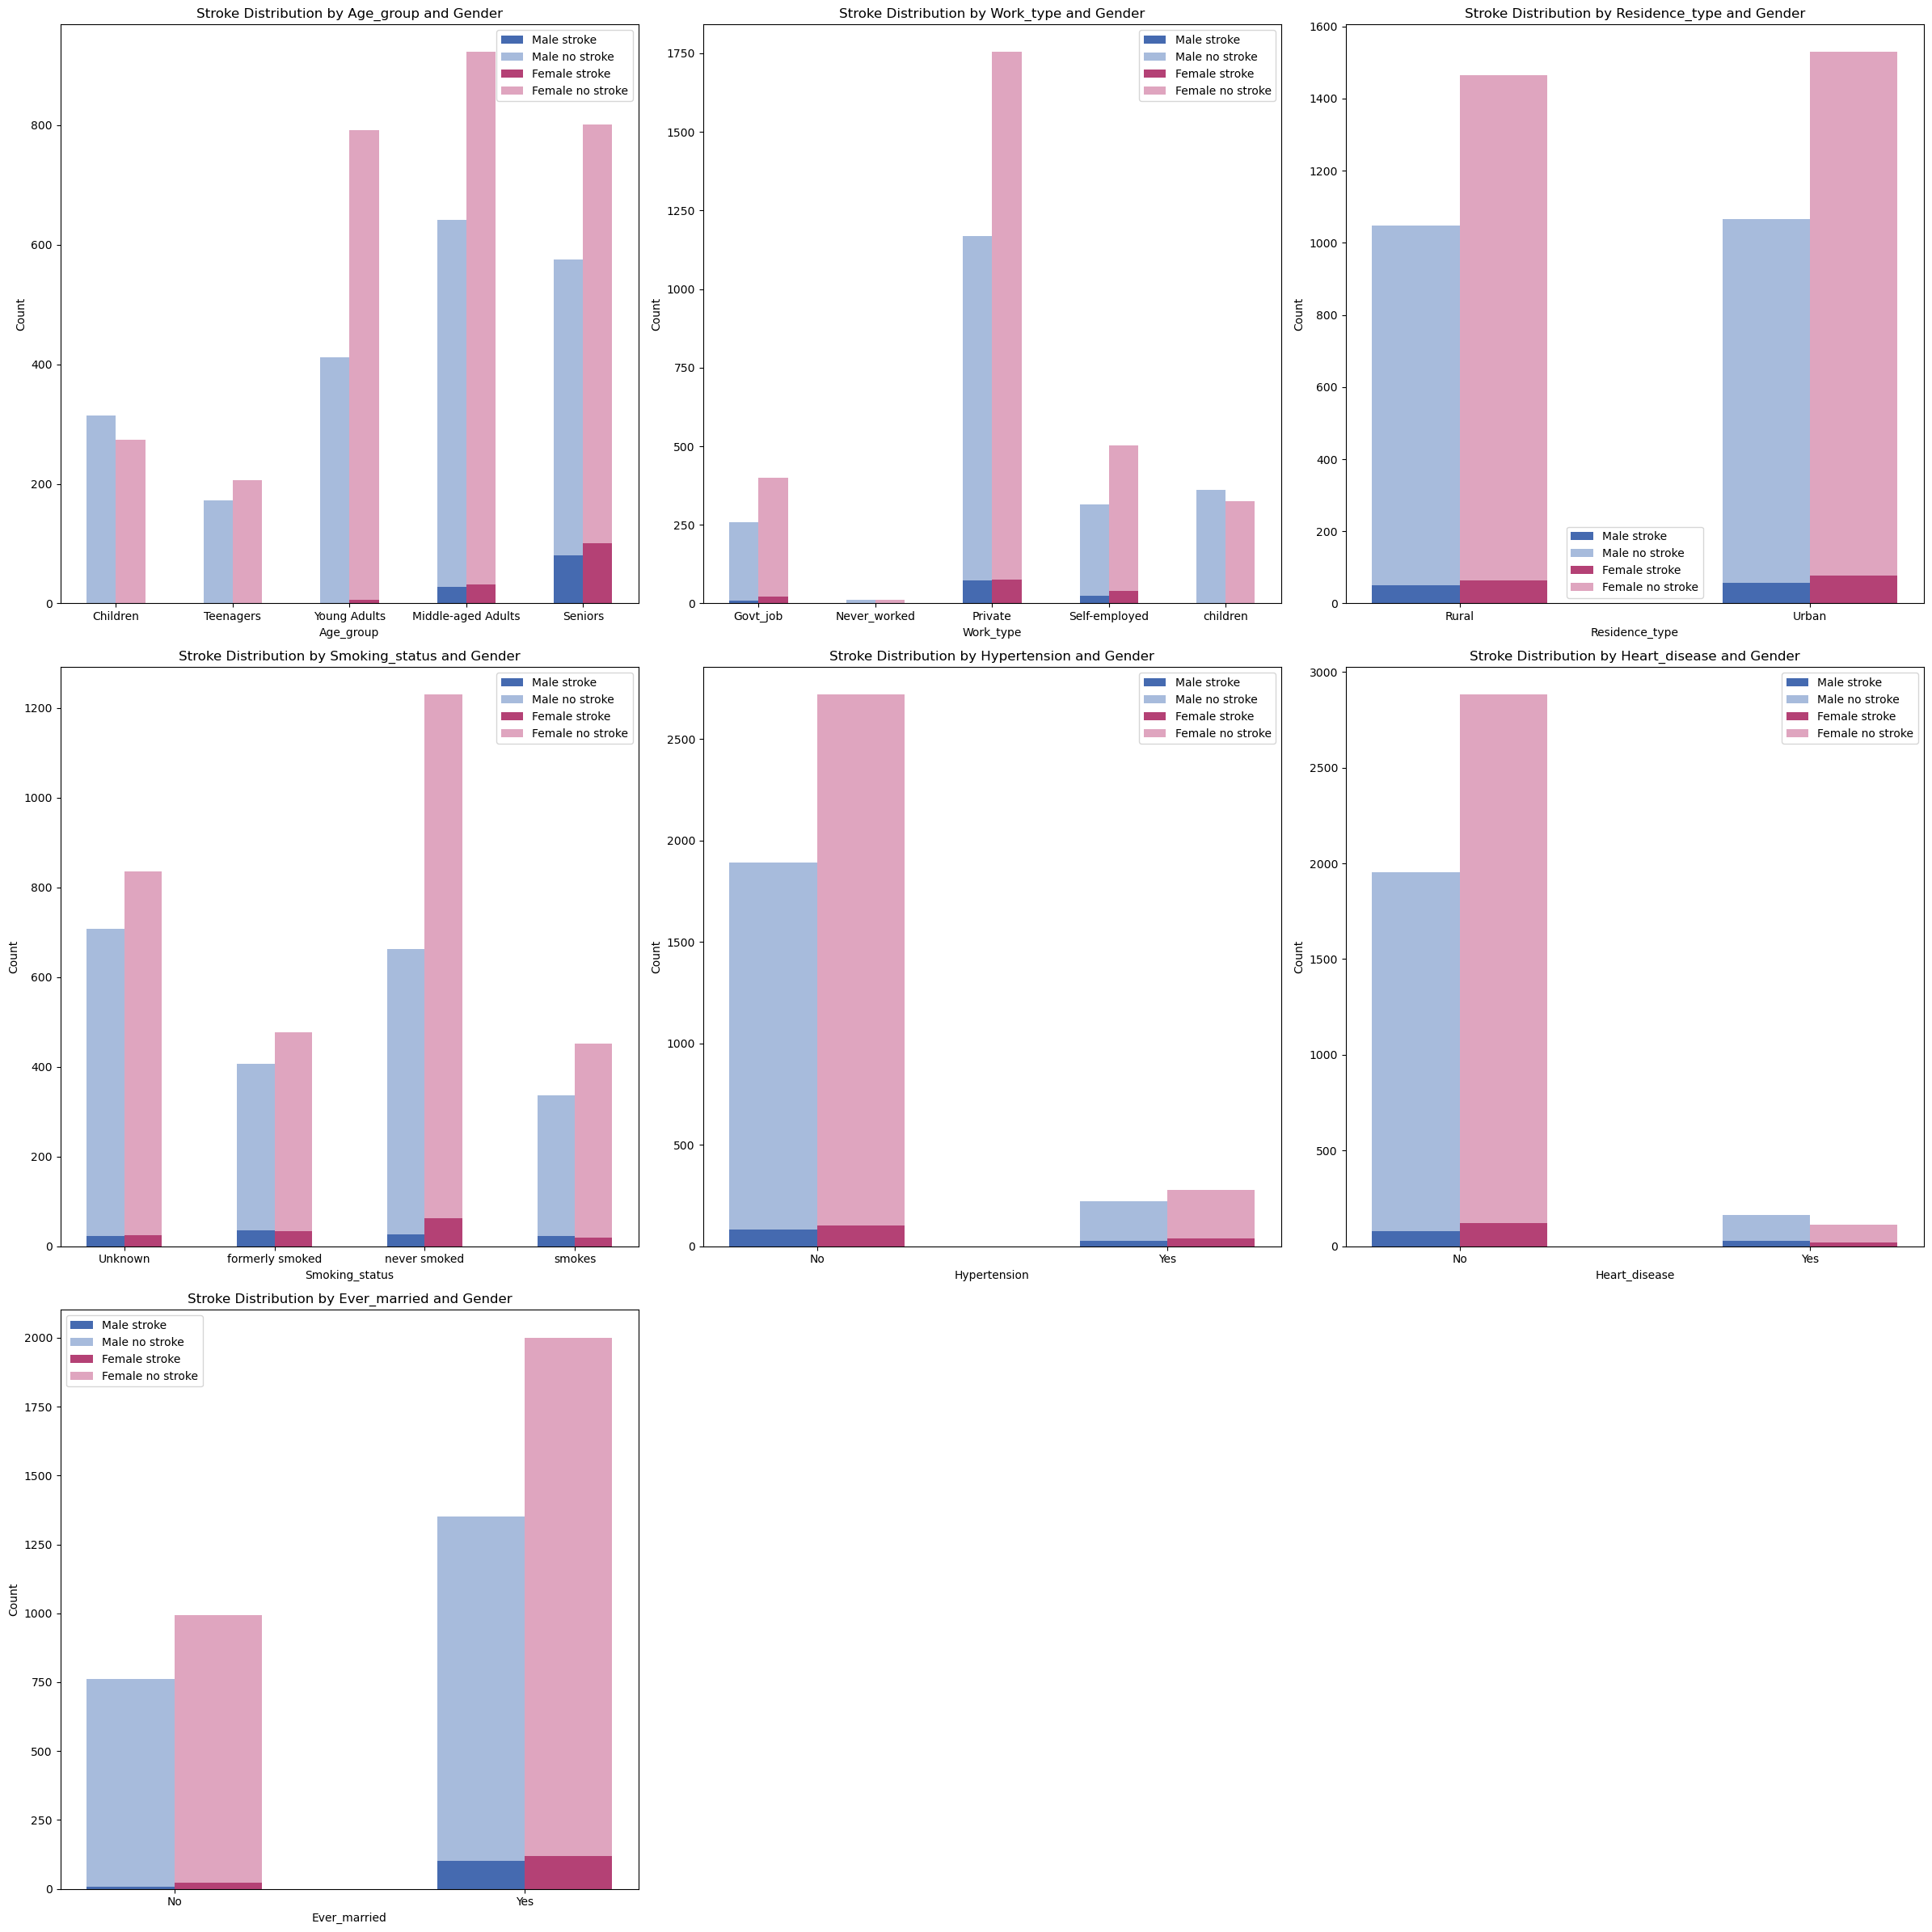

In [27]:


# List of variables to group by
group_vars = ["age_group", "work_type", "Residence_type", "smoking_status", "hypertension", "heart_disease", "ever_married"]

# Create grid
fig, axs = plt.subplots(3, 3, figsize=(24, 24))

# Flatten axs 
axs = axs.flatten()

# Set width of bar
barWidth = 0.25

# Function to set labels
def get_tick_labels(var, index):
    if var in ["hypertension", "heart_disease"]:
        return ["No", "Yes"]
    return index.astype(str)

# Iterate over group_vars and axs simultaneously
for var, ax in zip(group_vars, axs):
    # Group by var, "gender" and "stroke" and get the size of each group
    grouped = visualize_df.groupby([var, "gender", "stroke"]).size().unstack(level=[1, 2], fill_value=0)
    
    # Set position of bar on X axis
    r1 = np.arange(len(grouped.index))
    r2 = [x + barWidth for x in r1]

    # Create bars for each group
    for i, gender in enumerate(["Male", "Female"]):
        r = r1 if gender == "Male" else r2
        ax.bar(
            r, 
            grouped[(gender, 1)], 
            color="#456AB0" if gender == "Male" else "#B44175",
            width=barWidth,
            label=f"{gender} stroke"
        )
        ax.bar(
            r, 
            grouped[(gender, 0)], 
            bottom=grouped[(gender, 1)], 
            color="#A7BBDC" if gender == "Male" else "#DFA5BF", 
            width=barWidth,
            label=f"{gender} no stroke"
        )

    # Plot chart
    ax.set_xticks([r + barWidth/2 for r in range(len(grouped.index))])
    ax.set_xticklabels(get_tick_labels(var, grouped.index))
    ax.legend()
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel("Count")
    ax.set_title(f"Stroke Distribution by {var.capitalize()} and Gender")

# Remove unused subplots
for i in range(len(group_vars), len(axs)):
    fig.delaxes(axs[i])

# Display plots
plt.tight_layout()
plt.show()


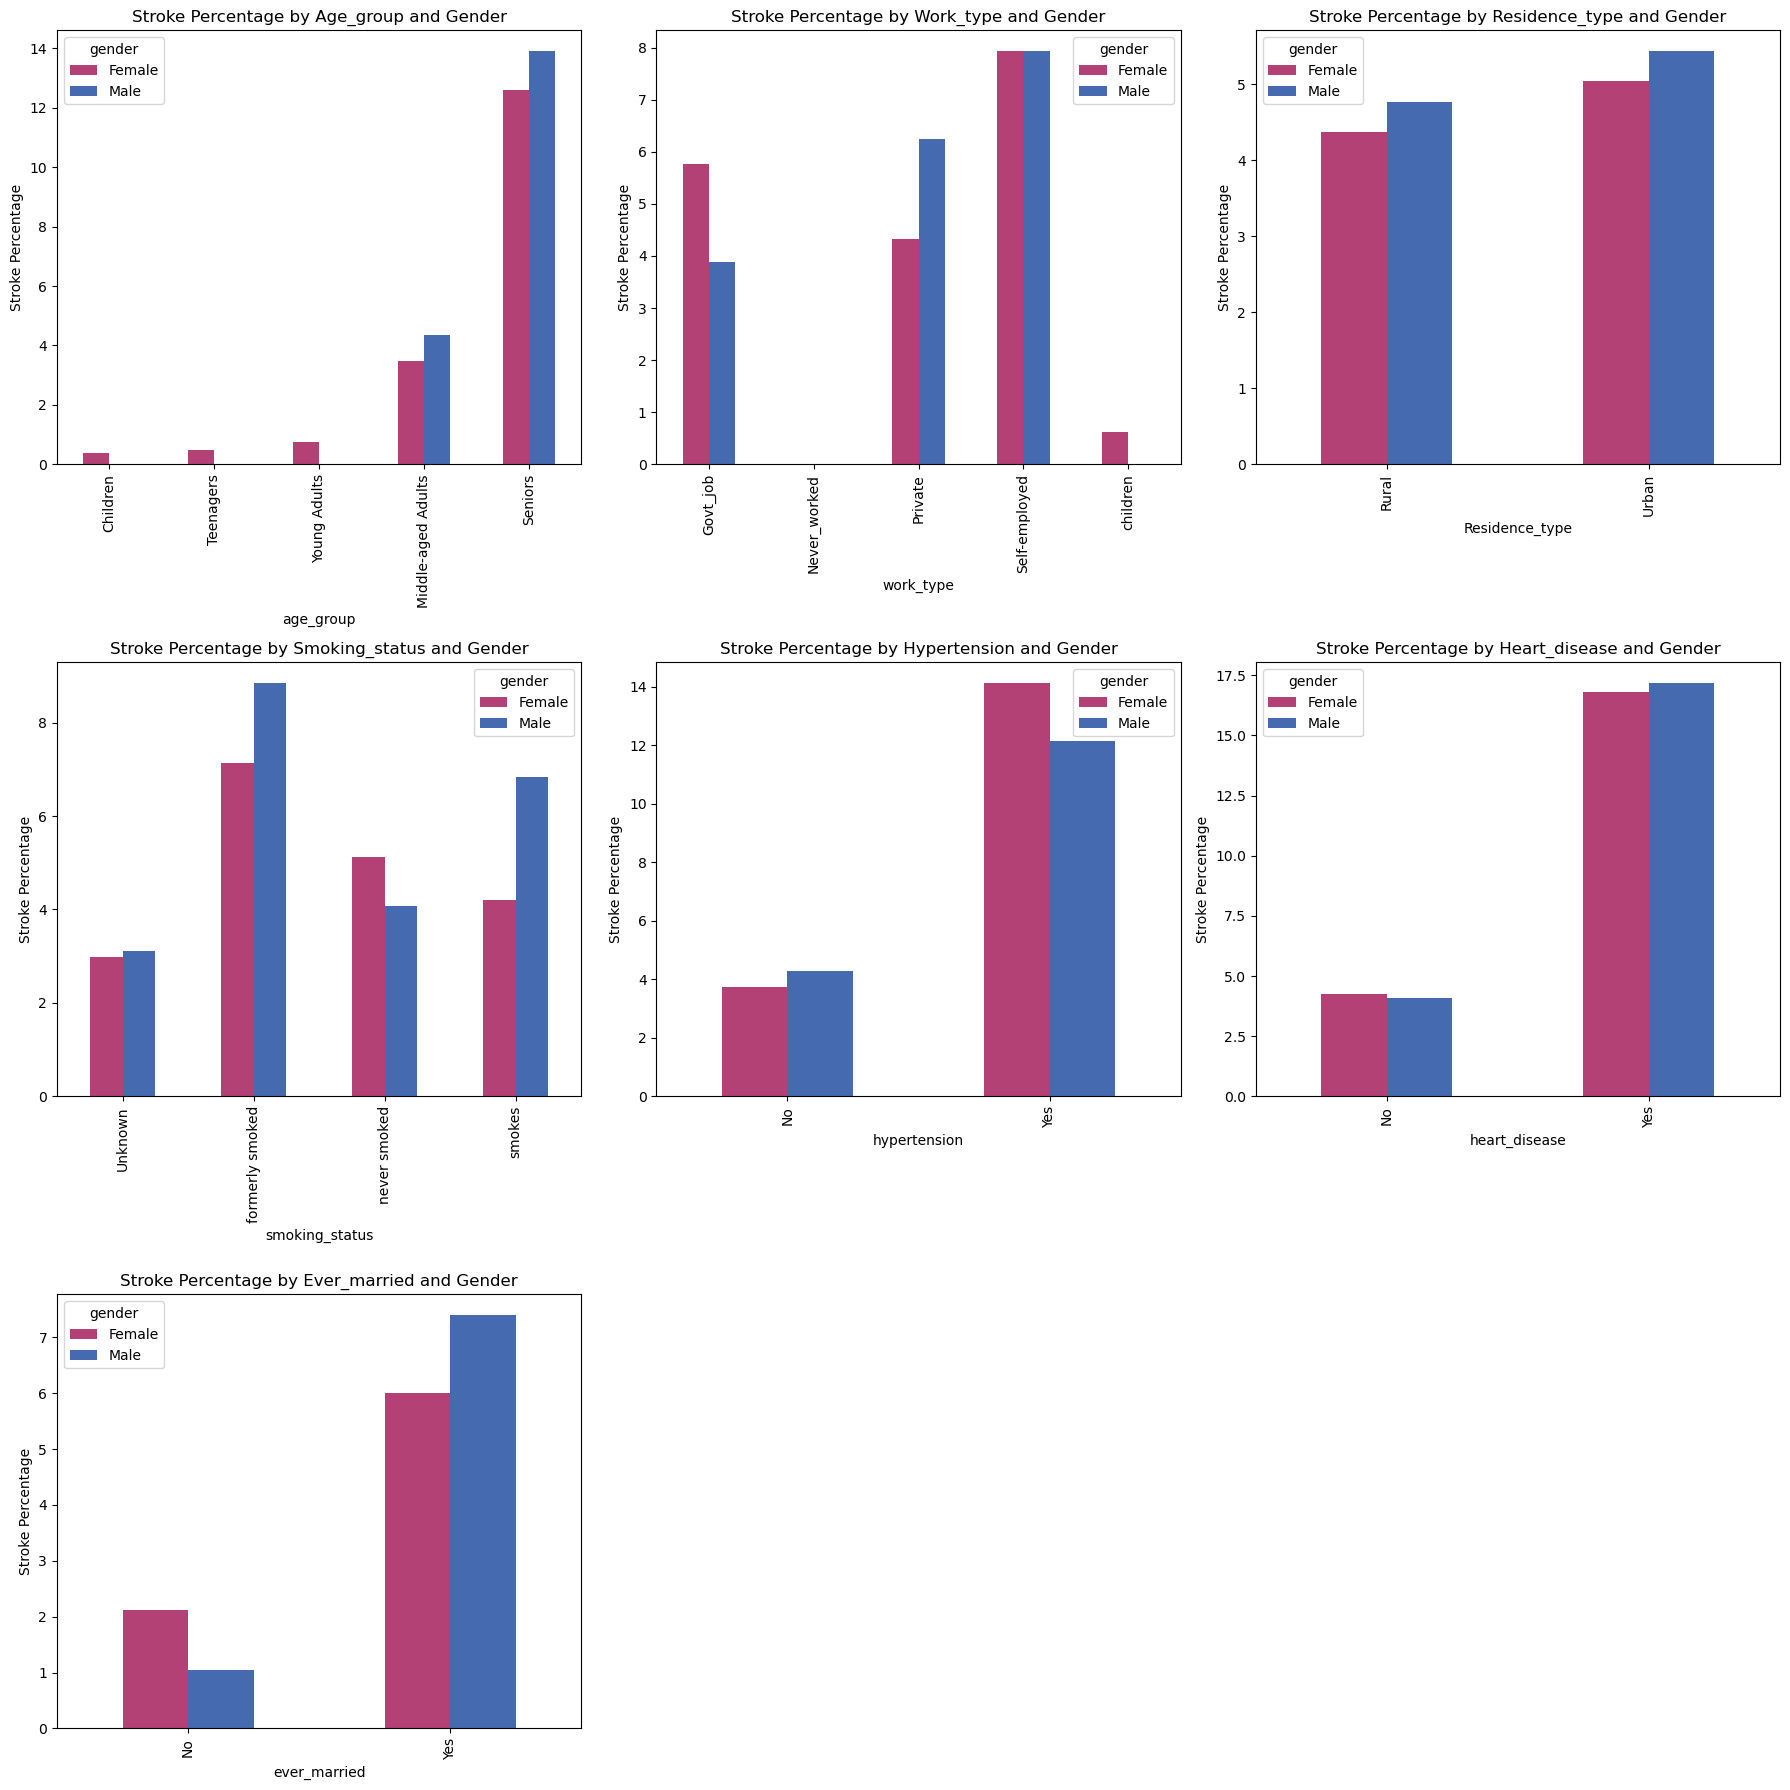

In [28]:


# List of variables to group by
variables = ["age_group", "work_type", "Residence_type", "smoking_status", "hypertension", "heart_disease", "ever_married"]

# Create grid 
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Flatten axs 
axs = axs.flatten()

# Function to set labels
def get_tick_labels(var, index):
    if var in ["hypertension", "heart_disease"]:
        return ["No", "Yes"]
    return index.astype(str)

# Iterate over variables and axs simultaneously
for i, var in enumerate(variables):
    ax = axs[i]
    grouped = visualize_df.groupby([var, "gender"])
    total = grouped.size()
    stroke_cases = grouped['stroke'].sum()
    stroke_percentage = (stroke_cases / total) * 100
    result = stroke_percentage.reset_index(name='stroke_percentage')
    
    result_pivot = result.pivot(index=var, columns="gender", values="stroke_percentage")
    
    
    tick_labels = get_tick_labels(var, result_pivot.index)
    
    result_pivot.plot(kind='bar', ax=ax, color=["#B44175", "#456AB0"])
    ax.set_title(f'Stroke Percentage by {var.capitalize()} and Gender')
    ax.set_ylabel('Stroke Percentage')
    ax.set_xticklabels(tick_labels)

# Remove unused subplots
for i in range(len(variables), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


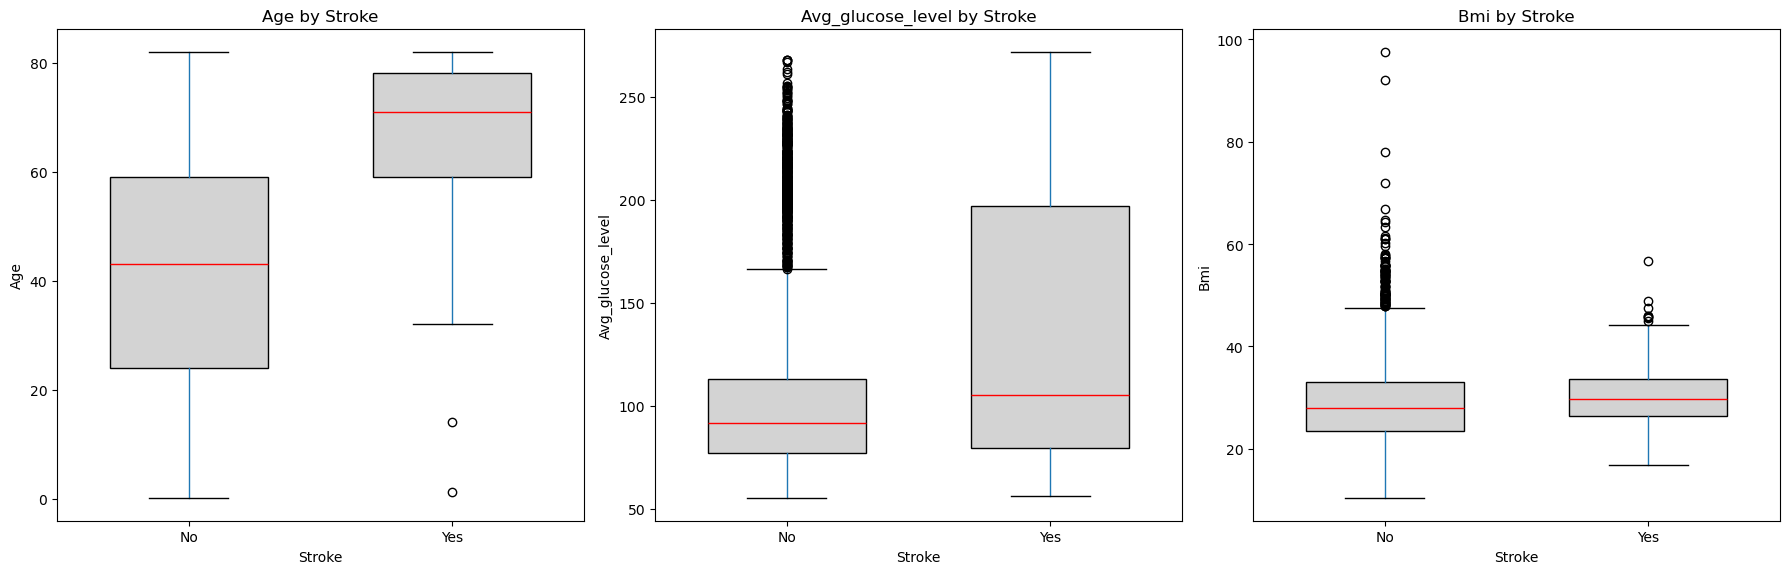

In [30]:


# List of numerical variables to plot
numerical_vars = ["age", "avg_glucose_level", "bmi"]

# Create grid 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over numerical_vars and axs 
for i, var in enumerate(numerical_vars):
    ax = axs[i]
    
    # Create boxplots for stroke = 0 and stroke = 1
    visualize_df.boxplot(column=var, by='stroke', ax=ax, grid=False, widths=0.6,
                    patch_artist=True, 
                    boxprops=dict(facecolor='#D3D3D3'),
                    medianprops=dict(color='red'))
    
    ax.set_title(f'{var.capitalize()} by Stroke')
    ax.set_xlabel('Stroke')
    ax.set_ylabel(var.capitalize())
    ax.set_xticklabels(['No', 'Yes'])
    
# Adjust layout
plt.suptitle('')  
plt.tight_layout()
plt.show()


<h3>Basic Preprocessing</h3>

In [7]:
#Splitting the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(work_df.drop(columns=["stroke"]), work_df["stroke"], test_size=0.2, random_state=42, stratify = work_df["stroke"])

#Filling missing values in the "bmi" column with the average BMI value
average_bmi = features_train["bmi"].mean()
features_train["bmi"].fillna(average_bmi, inplace=True)
features_test["bmi"].fillna(average_bmi, inplace=True)

In [20]:
# Encode categorical features
work_type_dummies_train, work_type_dummies_test = pd.get_dummies(features_train['work_type'], prefix='work_type'), pd.get_dummies(features_test['work_type'], prefix='work_type')
smoking_status_dummies_train, smoking_status_dummies_test = pd.get_dummies(features_train['smoking_status'], prefix='smoking_status'), pd.get_dummies(features_test['smoking_status'], prefix='smoking_status')

# Update train and test DataFrames with the encoded features
features_train_encoded = pd.concat([features_train, work_type_dummies_train, smoking_status_dummies_train], axis=1).drop(columns=["work_type", "smoking_status"])
features_test_encoded = pd.concat([features_test, work_type_dummies_test, smoking_status_dummies_test], axis=1).drop(columns=["work_type", "smoking_status"])

# Create a list of columns to remove from the DataFrames after statistical analysis
columns_to_remove = []

features_train_encoded.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
845,Female,48.0,0,0,Yes,Urban,69.21,33.1,0,0,1,0,0,0,0,1,0
3745,Female,29.0,0,0,No,Urban,84.19,21.2,0,0,1,0,0,0,0,1,0
4184,Female,35.0,0,0,Yes,Rural,119.40,22.9,0,0,1,0,0,0,0,1,0
3410,Male,38.0,0,0,Yes,Rural,108.68,32.7,0,0,1,0,0,0,0,1,0
284,Male,14.0,0,0,No,Urban,82.34,31.6,1,0,0,0,0,1,0,0,0


<h3>Statistical Analysis</h3>

Chi Squared Test

In [22]:
# Function to perform the Chi-Square test for categorical variables
def chi2_test(columns, features, target):
    results = {}
    for var in columns:
        contingency_table = pd.crosstab(features[var], target)
        chi2, p, dof, expected  = chi2_contingency(contingency_table)
        results[var] = {'Chi2': chi2, 'p-value': p}
        
    return results

# Store the results of the Chi-Square test for each categorical variable
results_ws = chi2_test(features_train_encoded.select_dtypes(exclude=["float64"]).columns, features_train_encoded.select_dtypes(exclude=["float64"]), target_train)

#Sort results by p-value
sorted_results = sorted(results_ws.items(), key=lambda x: x[1]['p-value'])

for var, result in sorted_results:
    print(f"Chi-Square Test for {var} and stroke:\n  Chi2 = {result['Chi2']}, p-value = {result['p-value']} \n")
    
    # If the p-value is greater than 0.05, add the variable to the list of columns to remove
    if result['p-value'] > 0.05:
        columns_to_remove.append(var)


print(columns_to_remove)

Chi-Square Test for hypertension and stroke:
  Chi2 = 74.01055324051025, p-value = 7.770052127521188e-18 

Chi-Square Test for heart_disease and stroke:
  Chi2 = 57.794371267437796, p-value = 2.910012324267957e-14 

Chi-Square Test for ever_married and stroke:
  Chi2 = 45.94085864345403, p-value = 1.2187730990642863e-11 

Chi-Square Test for work_type_children and stroke:
  Chi2 = 29.322499564020823, p-value = 6.128002260646012e-08 

Chi-Square Test for work_type_Self-employed and stroke:
  Chi2 = 19.079168748552775, p-value = 1.2540626531498955e-05 

Chi-Square Test for smoking_status_formerly smoked and stroke:
  Chi2 = 15.660013913126573, p-value = 7.581009961727429e-05 

Chi-Square Test for smoking_status_Unknown and stroke:
  Chi2 = 11.771158286575186, p-value = 0.0006015553455265994 

Chi-Square Test for Residence_type and stroke:
  Chi2 = 1.184990380117348, p-value = 0.27634239000847194 

Chi-Square Test for smoking_status_smokes and stroke:
  Chi2 = 0.5073558427872709, p-value 

Pearson Correlation

In [ ]:
# Create numerical features DataFrame for correlation analysis
corr_df = pd.concat([features_train_encoded.select_dtypes(include=["float64"]), target_train], axis=1)

# Perform correlation analysis using the Pearson method
correlation_matrix = corr_df.corr(method = "pearson")

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)))

Multiple Linear Regression

In [24]:
X = features_train_encoded.select_dtypes(include=["float64"])
Y = target_train

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model for the independent and dependent variables to perform statistical analysis
ols_model = sm.OLS(Y, X).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     98.25
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           2.11e-61
Time:                        10:04:24   Log-Likelihood:                 621.23
No. Observations:                4087   AIC:                            -1234.
Df Residuals:                    4083   BIC:                            -1209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0516      0.01

In [25]:
columns_to_remove

['Residence_type',
 'smoking_status_smokes',
 'gender',
 'work_type_Govt_job',
 'smoking_status_never smoked',
 'work_type_Never_worked',
 'work_type_Private']

In [26]:
# Remove the columns with no statistical significance on the train and test sets
features_train_encoded = features_train_encoded.drop(columns=columns_to_remove)
features_test_encoded = features_test_encoded.drop(columns=columns_to_remove)

<h3>Modelling</h3>

F2 Scoring Function

In [40]:
# Create f2_score function
def f2_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0
    f2 = (5 * precision * recall) / (4 * precision + recall)
    return f2

# Set up the f2_scorer and f1_minority_scorer
f2_scorer = make_scorer(f2_score, greater_is_better=True)
f1_minority_scorer = make_scorer(f1_score, pos_label=1)

Models

In [56]:
# Create a dictionary of models with their respective hyperparameters
models = {
    'XGBoost': (XGBClassifier(subsample=0.6, n_estimators=400, min_child_weight=5, max_depth=8, learning_rate=7.906043210907701e-05, gamma=0.3, colsample_bytree=0.7, eval_metric="auc"), {
        'classifier__learning_rate': np.logspace(-5, -1, 50),
        'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'classifier__min_child_weight': [1, 3, 5, 7],
        'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__n_estimators': [100, 200, 300, 400, 500]
    }),
    'RandomForest': (RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=10, max_features="sqrt", criterion="entropy", class_weight="balanced", bootstrap=True), {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': [1, 5, 10, 50, 'sqrt', 'log2'],
        'classifier__bootstrap': [True, False]
    }),
    'KNN': (KNeighborsClassifier(n_neighbors=5), {
        'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'classifier__leaf_size': [10, 20, 30, 40, 50],
        'classifier__p': [1, 2]  
     }),
    'LogisticRegression': (LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced'), [
        # L2 penalty with solvers newton-cg, lbfgs, sag, saga
        {
            'classifier__penalty': ['l2'],
            'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'classifier__C': np.logspace(-4, 4, 50),
            'classifier__max_iter': [100, 200, 300, 500, 1000],
            'classifier__class_weight': [None, 'balanced']
        },
        # L1 penalty with solvers liblinear and saga
        {
            'classifier__penalty': ['l1'],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__C': np.logspace(-4, 4, 50),
            'classifier__max_iter': [100, 200, 300, 500, 1000],
            'classifier__class_weight': [None, 'balanced']
        },
        # Elasticnet penalty with solver saga
        {
            'classifier__penalty': ['elasticnet'],
            'classifier__solver': ['saga'],
            'classifier__C': np.logspace(-4, 4, 50),
            'classifier__max_iter': [100, 200, 300, 500, 1000],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__l1_ratio': np.linspace(0, 1, 10)
        },
        # None penalty with solver lbfgs (for no regularization)
        {
            'classifier__penalty': ['none'],
            'classifier__solver': ['lbfgs'],
            'classifier__C': [1],  # C is not used, but it needs a placeholder value
            'classifier__max_iter': [100, 200, 300, 500, 1000],
            'classifier__class_weight': [None, 'balanced']
        }
    ]),
     'LightGBM' : (LGBMClassifier(boosting_type='gbdt', objective='binary', class_weight='balanced', n_jobs=-1, random_state=42, verbosity = -1), {
         'classifier__num_leaves': [31, 41, 51, 61, 71],  
         'classifier__max_depth': [-1, 10, 20, 30, 40, 50],  
         'classifier__learning_rate': np.logspace(-4, 0, 50),  
         'classifier__n_estimators': [100, 200, 300, 400, 500],  
         'classifier__min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],  
         'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  
         'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  
         'classifier__reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5],  
         'classifier__reg_lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5],  
         'classifier__scale_pos_weight': [1, 10, 20, 30, 40, 50]  
    })
}

In [57]:
# Create a preprocessor pipeline to normalize numerical features and encode binary features for the models
preprocessor = ColumnTransformer(
    transformers=[
        ('normalizer', PowerTransformer(), make_column_selector(dtype_include=['float64'])),
        ('binary_encoder', OrdinalEncoder(), make_column_selector(dtype_include=['object', 'bool']))
    ])

# Create a SMOTETomek balancer to handle the imbalanced dataset
balancer = SMOTETomek()

# Function to fit the model using RandomizedSearchCV and display the best F2-Score and parameters
def fit_model(model_name, model, param_grid, features_train, target_train, scoring, cv=10, n_iter=100, random_state=42, n_jobs=-1):
    # Create an ImbPipeline with the preprocessor, balancer, and model
    pipeline = ImbPipeline(steps=[
        ('processor', preprocessor),
        ('balancer', balancer),
        ('classifier', model)
    ])
    
    # Create a RandomizedSearchCV object with the pipeline, parameters, and scoring method
    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring=scoring, cv=cv, n_iter=n_iter, random_state=random_state, n_jobs=n_jobs)
    grid_search.fit(features_train, target_train)
    
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(f'{model_name}:\nF2-Score : {best_score:.2f}%')
    print('Best Parameters :', best_params)
    print('\n')
    
    return grid_search, best_params

# Store the best models and their parameters of the hyperparameter tuning
best_models = {}
for model_name, (model, param_grid) in models.items():
    best_model, best_params = fit_model(model_name, model, param_grid, features_train_encoded, target_train, scoring=f2_scorer)
    best_models[model_name] = (best_model, best_params)

XGBoost:
F2-Score : 0.39%
Best Parameters : {'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 3, 'classifier__max_depth': 5, 'classifier__learning_rate': np.float64(3.727593720314938e-05), 'classifier__gamma': 0.4, 'classifier__colsample_bytree': 0.7}


RandomForest:
F2-Score : 0.37%
Best Parameters : {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__bootstrap': True}


KNN:
F2-Score : 0.35%
Best Parameters : {'classifier__weights': 'uniform', 'classifier__p': 1, 'classifier__n_neighbors': 21, 'classifier__leaf_size': 50, 'classifier__algorithm': 'brute'}


LogisticRegression:
F2-Score : 0.40%
Best Parameters : {'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__max_iter': 300, 'classifier__l1_ratio': np.float64(0.3333333333333333), 'classifier__class_weight': 'balanced', 'classifi

In [61]:
# Function to perform cross-validation on the best model and display the F2-Score
def cross_validate_best_model(model_name, best_model, features, target, cv=10, scoring=f2_scorer):
    # Extract the best model and parameters
    best_params = best_model.best_params_
    classifier = best_model.best_estimator_['classifier']
    
    # Create a new pipeline with the best model and parameters
    pipeline = ImbPipeline(steps=[
        ('processor', preprocessor),
        ('balancer', balancer),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, features, target, cv=cv, scoring=scoring, n_jobs=-1)
    
    print(f'{model_name} Cross-Validation F2-Score: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')
    
    return cv_scores

# Perform cross-validation and store evaluation results
cv_scores_dict = {}
for model_name, (best_model, _) in best_models.items():
    cv_scores = cross_validate_best_model(model_name, best_model, features_train_encoded, target_train)
    cv_scores_dict[model_name] = cv_scores

# Define the metrics to evaluate the models
metrics = {
    'Accuracy': accuracy_score,
    'Precision': lambda target_test, pred: precision_score(target_test, pred, average='binary'),
    'Recall': recall_score,
    'F1': f1_score,
    'Roc_auc': roc_auc_score,
    'Balanced_accuracy' : balanced_accuracy_score,
}

# Evaluate the best models on the test set and display the metric scores
for model_name, (best_model, _) in best_models.items():
    pred = best_model.predict(features_test_encoded)
    
    print(f"\n{model_name} - Metric Scores:")
    for metric_name, metric_func in metrics.items():
        try:
            score = metric_func(target_test, pred)
            print(f"{metric_name}: {score:.2f}")
        except ValueError as e:
            print(f"Error calculating {metric_name}: {e}")
            print(f"{metric_name}: {score:.2f}")
            
    cm = confusion_matrix(target_test, pred)
    print("\nConfusion Matrix:\n", cm)
    
    print("\nClassification Report:\n", classification_report(target_test, pred))
    print("__________________________________________________________________________________________\n")

XGBoost Cross-Validation F2-Score: 0.38 ± 0.05
RandomForest Cross-Validation F2-Score: 0.34 ± 0.07
KNN Cross-Validation F2-Score: 0.33 ± 0.05
LogisticRegression Cross-Validation F2-Score: 0.40 ± 0.04
LightGBM Cross-Validation F2-Score: 0.39 ± 0.05

XGBoost - Metric Scores:
Accuracy: 0.72
Precision: 0.12
Recall: 0.72
F1: 0.20
Roc_auc: 0.72
Balanced_accuracy: 0.72

Confusion Matrix:
 [[698 274]
 [ 14  36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.72      0.20        50

    accuracy                           0.72      1022
   macro avg       0.55      0.72      0.51      1022
weighted avg       0.94      0.72      0.80      1022

__________________________________________________________________________________________


RandomForest - Metric Scores:
Accuracy: 0.79
Precision: 0.14
Recall: 0.66
F1: 0.23
Roc_auc: 0.73
Balanced_accuracy: 0.73

Confusion Matrix:
 [[770 